In [1]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from matplotlib import cm as mpl_colormaps
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

import models
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from common import notebook_utils 
from common.notebook_utils import *
from common.utils import CenteredNorm
from gnncsvae_experiment import GNNCSVAEExperiment

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [3]:
# these two will be used any time we load a saved checkppoint

PROJECT_ROOT = r"D:\Saarbrucken\EDA_Research\vae-disentanglement"
datapath = os.path.join(PROJECT_ROOT, "datasets")
os.environ['DISENTANGLEMENT_LIB_DATA'] = datapath

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "kl_warmup_epochs",
                                         "adjacency_matrix", "loss_terms", "use_loss_weights"])

ExpParams = dict(
        in_channels=-1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset=None,
        datapath=datapath,
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)



In [4]:
# load the learned model here

algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = os.path.join(PROJECT_ROOT, "models", "pendulum200epoch1dim.ckpt")
z_dim = 1
channels = 3
l_dim = 5
num_nodes = 4
dataset = "pendulum"
current_device = torch.device("cuda:0")

# prep params
model_params = ModelParams(
        [z_dim], l_dim, 0, channels, 64, 64, 0.80, 0.15, 0,
        os.path.join(PROJECT_ROOT, "adjacency_matrices", f"{dataset}.pkl"),
        [], False
)

ExpParams['channels'] = channels

# load model
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=ExpParams,
            dataset_params=None).to(current_device)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.]])
GNNBasedConceptStructuredVAE Model Initialized


In [5]:
# load data
dataset = get_configured_dataset(dataset)
sample_loader = DataLoader(dataset, batch_size=64, shuffle = False, drop_last=True)

In [6]:
# Load the activations

mu_batches, label_batches = csvaegnn_get_latent_activations_with_labels_for_scatter(vae_model, sample_loader, 
                                                                                    current_device, batches = 110)
print(mu_batches.shape, label_batches.shape)

(7040, 4, 1) (7040, 5)


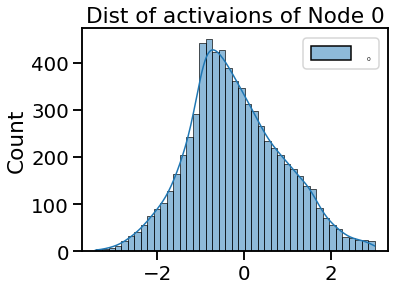

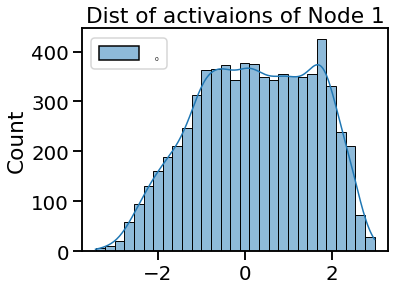

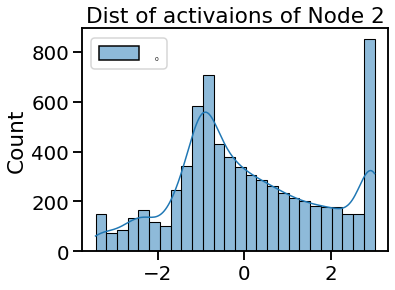

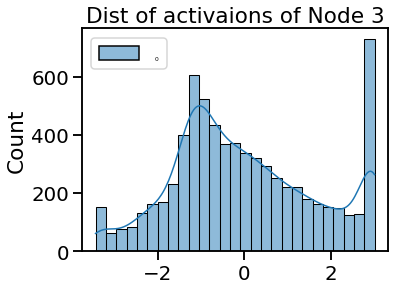

In [7]:
for node_idx in range(vae_model.num_nodes):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(5.5, 4.1)
    sns.histplot(mu_batches[:, node_idx], kde=True, ax=ax)
    plt.title(f"Dist of activaions of Node {node_idx}")
    plt.setp(ax.get_legend().get_texts(), fontsize='6') # for legend text
    plt.show()


In [ ]:
# plot 1-D activations against the ground truth label hued by gt label
hue_factors = ['theta', 'phi', 'shade','mid']
for node_idx in range(self.model.num_nodes):
    for h, hue_factor in enumerate(hue_factors):

        fig, ax = plt.subplots()
        fig.set_size_inches(11.7, 8.27)

        x_plot, y_plot = mus[:, node_idx, 0], true_labels

        sns.scatterplot(   
            x=x_plot, 
            y=y_plot, 
            hue=labels[:,h], 
            s=15, 
            ax=ax
        )
        # for legend text
        plt.setp(ax.get_legend().get_texts(), fontsize='10')

        ax.set_xlabel(r"$Z_1$",fontsize=15)
        ax.set_ylabel(r"$Z_2$",fontsize=15)
        ax.set(ylim=ylim)
        ax.set(xlim=(-5, 5))
        plt.title(f"Node {node_idx}. Hue by {hue_factor}")

tensor([33.0000, -0.9091, -0.1750, -0.3019, -0.0776])


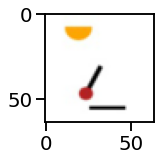

In [8]:
# get any one image
imgs, labels = next(sample_loader.__iter__())
print(labels[33])
anchor_image = imgs[33]
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(anchor_image.permute(1,2,0), cmap='gray')
anchor_image = anchor_image.unsqueeze(0).to(current_device)

Visualizing latent space from -3.54 to 2.56, with center at 3.05


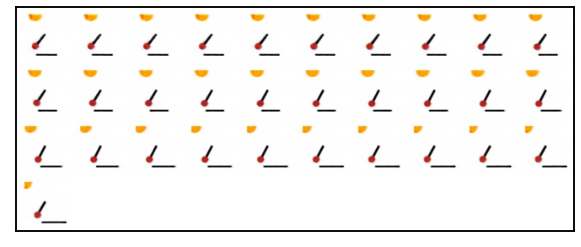

In [13]:
# node 0 -- pen angle

# Sun moves to left slightly. 
# Shadow length changes a bit. 
# Pendulum angle stays the same
# Shadow position stays the same

# (Sun, Shadow Len) change
# (Pendulum Angle, Shadow Pos) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=0, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

Visualizing latent space from -3.44 to 2.66, with center at 3.05


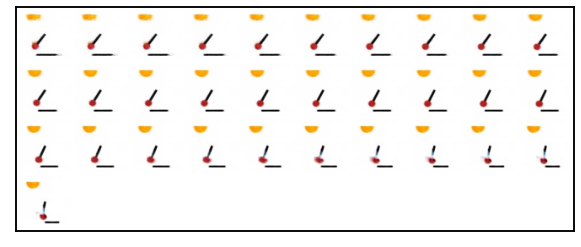

In [14]:
# node 1 -- light position

# Pendulum angle changes - but not full rotation
# Shadow position also varies slightly
# Shadow length decreases a bit
# Sun stays the same

# (Pendulum Angle, Shadow Pos, Shadow Len) change
# (Sun,) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=1, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

Visualizing latent space from -3.48 to 2.62, with center at 3.05


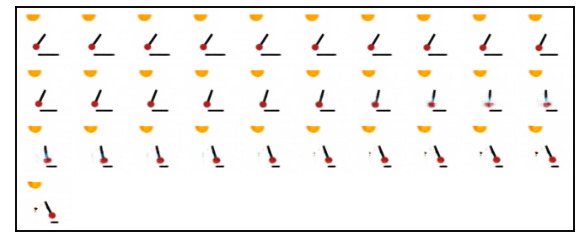

In [15]:
# node 2 -- shadow length

# Pendulum swings from left to right. 
# Shadow length changes
# Shadow position changes
# Sun stays the same. 

# (Pendulum Angle, Shadow Pos, Shadow Len) change
# (Sun,) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=2, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

Visualizing latent space from -3.41 to 2.69, with center at 3.05


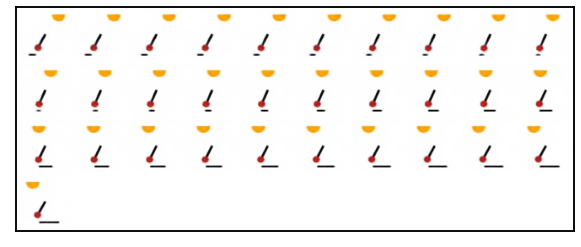

In [16]:
# node 3 -- shadow position

# Sun source moves from right to left. 
# Shadow length changes. 
# Shadow position changes
# Pendulum angle stays same

# (Sun, Shadow Pos, Shadow Len) change
# (Pendulum Angle,) stays same

csvaegnn_show_traversal_images(vae_model, anchor_image, limit=3, interp_step=1/5, node_to_explore=3, 
                               dim_to_explore=0,nrow=10, figsize=(10, 10))

In [ ]:
# Aliasing of cause and effect -- right now it appears that as i perturb this node the pendulum angle changes and in response the 
# shadow length also changes.. But it could be my projecting my causal understanding onto the network.. Who's to say that 
# in actuality perturbing the node changes the shadow length and the network then draws the appropriate pendulum stem angle.
# How can we be sure of directionality in these kind of traversal demonstrations?

# To resolve this we need to identify the cause and effect node and then vary both one at a time
# only cause node should exhibit this behaviour 
